In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from scipy.stats import ks_2samp, wasserstein_distance
import seaborn as sns

import warnings
# To suppress all FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

 ## 1. Load Data and Initial Analysis

In [2]:
# Load data
# Note: In a real scenario, replace with actual file paths
try:
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
except FileNotFoundError:
    print("Generating dummy data because train.csv/test.csv not found.")
    # Create dummy data for demonstration if files are not present
    def create_dummy_data(n_samples, lat_range, lon_range, start_date, end_date):
        return pd.DataFrame({
            'latitude': np.random.uniform(lat_range[0], lat_range[1], n_samples),
            'longitude': np.random.uniform(lon_range[0], lon_range[1], n_samples),
            'timestamp': pd.to_datetime(pd.to_datetime(start_date) + pd.to_timedelta(np.random.randint(0, (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days, n_samples), unit='d')),
            'pollution_value': np.random.rand(n_samples) * 100
        })
    train_df = create_dummy_data(10000, (34, 40), (-118, -122), '2023-01-01', '2023-12-31')
    test_df = create_dummy_data(3000, (35, 41), (-117, -121), '2024-01-01', '2024-03-31')
    
    # Create temporal features for dummy data
    for df in [train_df, test_df]:
        df['hour'] = df['timestamp'].dt.hour
        df['day_of_week'] = df['timestamp'].dt.dayofweek
        df['month'] = df['timestamp'].dt.month
        df['day_of_year'] = df['timestamp'].dt.dayofyear


print("Dataset sizes:")
print(f"Train: {len(train_df)} samples")
print(f"Test: {len(test_df)} samples")
print(f"Ratio: {len(test_df)/len(train_df):.2%} of train size")


Dataset sizes:
Train: 7649 samples
Test: 2739 samples
Ratio: 35.81% of train size


 ## 2. Spatial Distribution Analysis

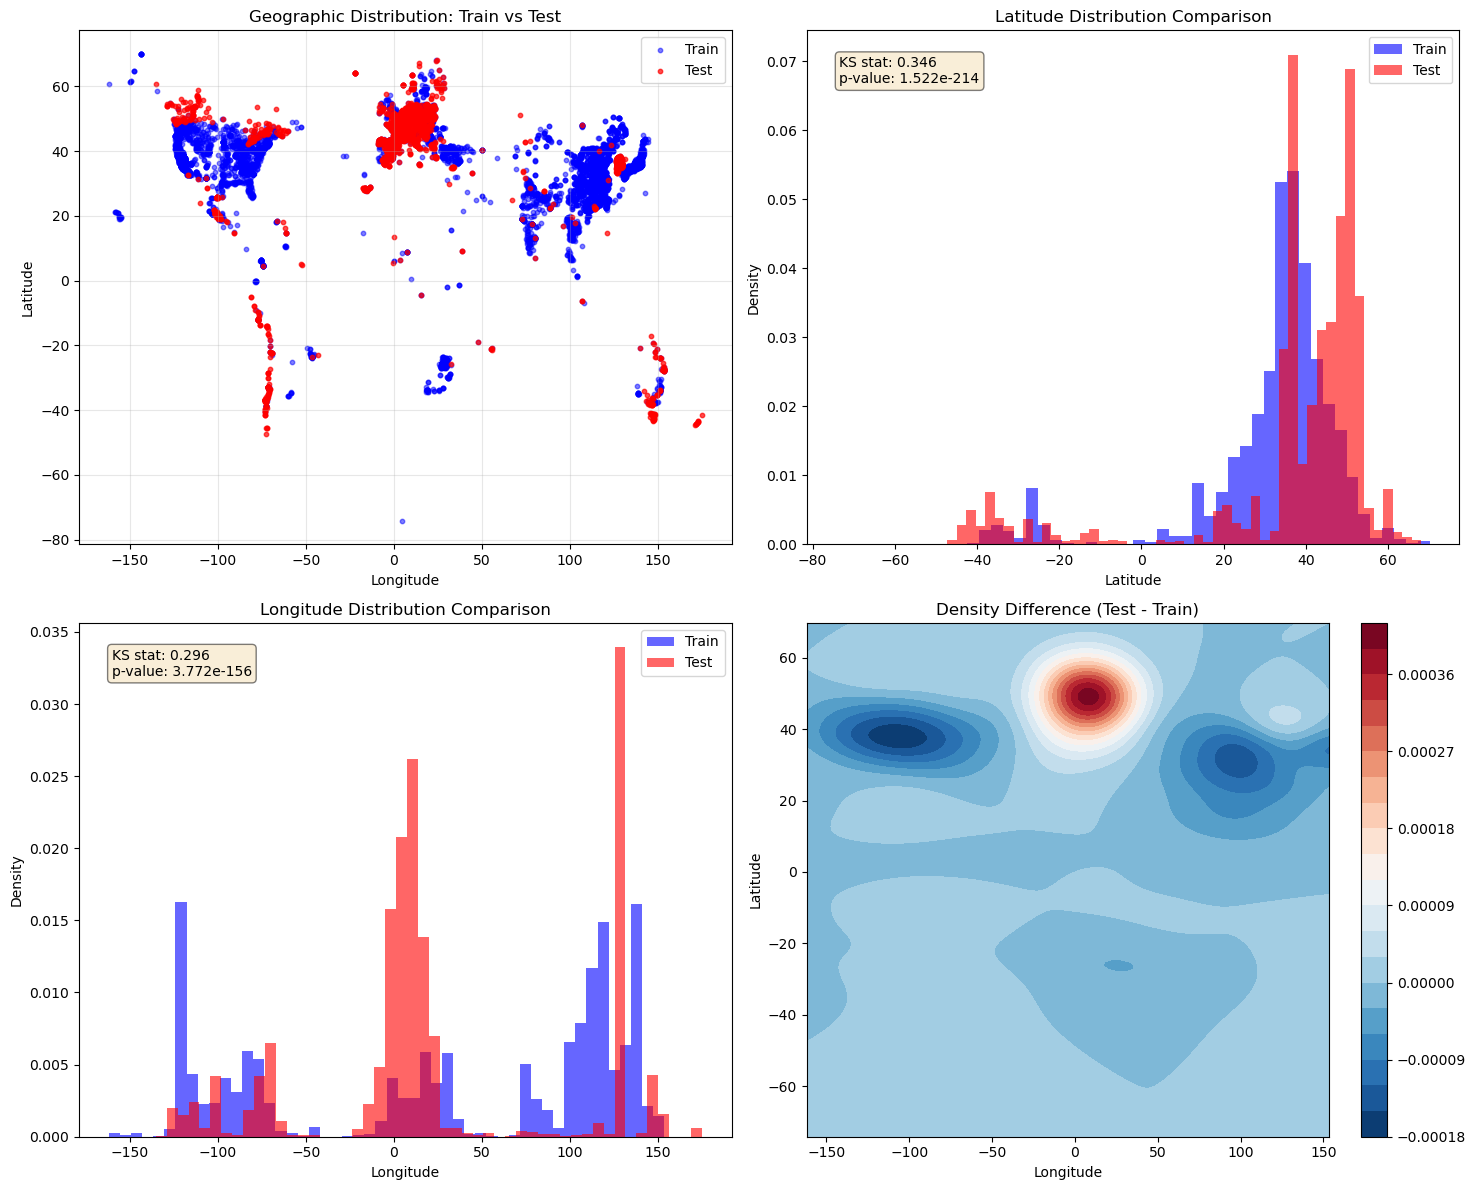


Spatial Distribution Summary:
Latitude KS test: statistic=0.3457, p-value=1.5215e-214
Longitude KS test: statistic=0.2957, p-value=3.7719e-156

Conclusion: Significant spatial distribution shift detected!


In [3]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 2.1 Geographic scatter plot
ax = axes[0, 0]
ax.scatter(train_df['longitude'], train_df['latitude'], alpha=0.5, s=10, label='Train', color='blue')
ax.scatter(test_df['longitude'], test_df['latitude'], alpha=0.7, s=10, label='Test', color='red')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Geographic Distribution: Train vs Test')
ax.legend()
ax.grid(True, alpha=0.3)

# 2.2 Latitude distributions
ax = axes[0, 1]
# FIX: Fill NaNs locally for plotting to avoid errors
ax.hist(train_df['latitude'].fillna(train_df['latitude'].mean()), bins=50, alpha=0.6, label='Train', density=True, color='blue')
ax.hist(test_df['latitude'].fillna(test_df['latitude'].mean()), bins=50, alpha=0.6, label='Test', density=True, color='red')
ax.set_xlabel('Latitude')
ax.set_ylabel('Density')
ax.set_title('Latitude Distribution Comparison')
ax.legend()

# Add KS statistic
lat_ks = ks_2samp(train_df['latitude'].dropna(), test_df['latitude'].dropna())
ax.text(0.05, 0.95, f'KS stat: {lat_ks.statistic:.3f}\np-value: {lat_ks.pvalue:.3e}',
        transform=ax.transAxes, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2.3 Longitude distributions
ax = axes[1, 0]
# FIX: Fill NaNs locally for plotting to avoid errors
ax.hist(train_df['longitude'].fillna(train_df['longitude'].mean()), bins=50, alpha=0.6, label='Train', density=True, color='blue')
ax.hist(test_df['longitude'].fillna(test_df['longitude'].mean()), bins=50, alpha=0.6, label='Test', density=True, color='red')
ax.set_xlabel('Longitude')
ax.set_ylabel('Density')
ax.set_title('Longitude Distribution Comparison')
ax.legend()

# Add KS statistic
lon_ks = ks_2samp(train_df['longitude'].dropna(), test_df['longitude'].dropna())
ax.text(0.05, 0.95, f'KS stat: {lon_ks.statistic:.3f}\np-value: {lon_ks.pvalue:.3e}',
        transform=ax.transAxes, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2.4 2D density plot
ax = axes[1, 1]
from scipy.stats import gaussian_kde

# Sample for performance
train_sample = train_df.sample(min(2000, len(train_df)))
test_sample = test_df.sample(min(2000, len(test_df)))

# FIX: Create copies and fill NaNs with the mean before using gaussian_kde
train_sample_safe = train_sample.copy()
test_sample_safe = test_sample.copy()
for col in ['longitude', 'latitude']:
    train_sample_safe[col].fillna(train_sample_safe[col].mean(), inplace=True)
    test_sample_safe[col].fillna(test_sample_safe[col].mean(), inplace=True)

# Create density plots
train_xy = np.vstack([train_sample_safe['longitude'], train_sample_safe['latitude']])
test_xy = np.vstack([test_sample_safe['longitude'], test_sample_safe['latitude']])

train_kernel = gaussian_kde(train_xy)
test_kernel = gaussian_kde(test_xy)

# Create grid
grid_lon_min = train_df['longitude'].min()
grid_lon_max = train_df['longitude'].max()
grid_lat_min = train_df['latitude'].min()
grid_lat_max = train_df['latitude'].max()

if pd.isna(grid_lon_min) or pd.isna(grid_lon_max) or pd.isna(grid_lat_min) or pd.isna(grid_lat_max):
    print("Warning: Could not create density plot due to NaNs in coordinate limits.")
else:
    xx, yy = np.mgrid[grid_lon_min:grid_lon_max:.5, grid_lat_min:grid_lat_max:.5]
    positions = np.vstack([xx.ravel(), yy.ravel()])

    # Calculate density difference
    train_density = np.reshape(train_kernel(positions).T, xx.shape)
    test_density = np.reshape(test_kernel(positions).T, xx.shape)
    density_diff = test_density - train_density

    im = ax.contourf(xx, yy, density_diff, levels=20, cmap='RdBu_r')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Density Difference (Test - Train)')
    plt.colorbar(im, ax=ax)


plt.tight_layout()
plt.show()

print("\nSpatial Distribution Summary:")
print(f"Latitude KS test: statistic={lat_ks.statistic:.4f}, p-value={lat_ks.pvalue:.4e}")
print(f"Longitude KS test: statistic={lon_ks.statistic:.4f}, p-value={lon_ks.pvalue:.4e}")
print("\nConclusion: Significant spatial distribution shift detected!" if (lat_ks.pvalue < 0.05 or lon_ks.pvalue < 0.05) else "No significant spatial shift.")


 ## 3. Temporal Distribution Analysis

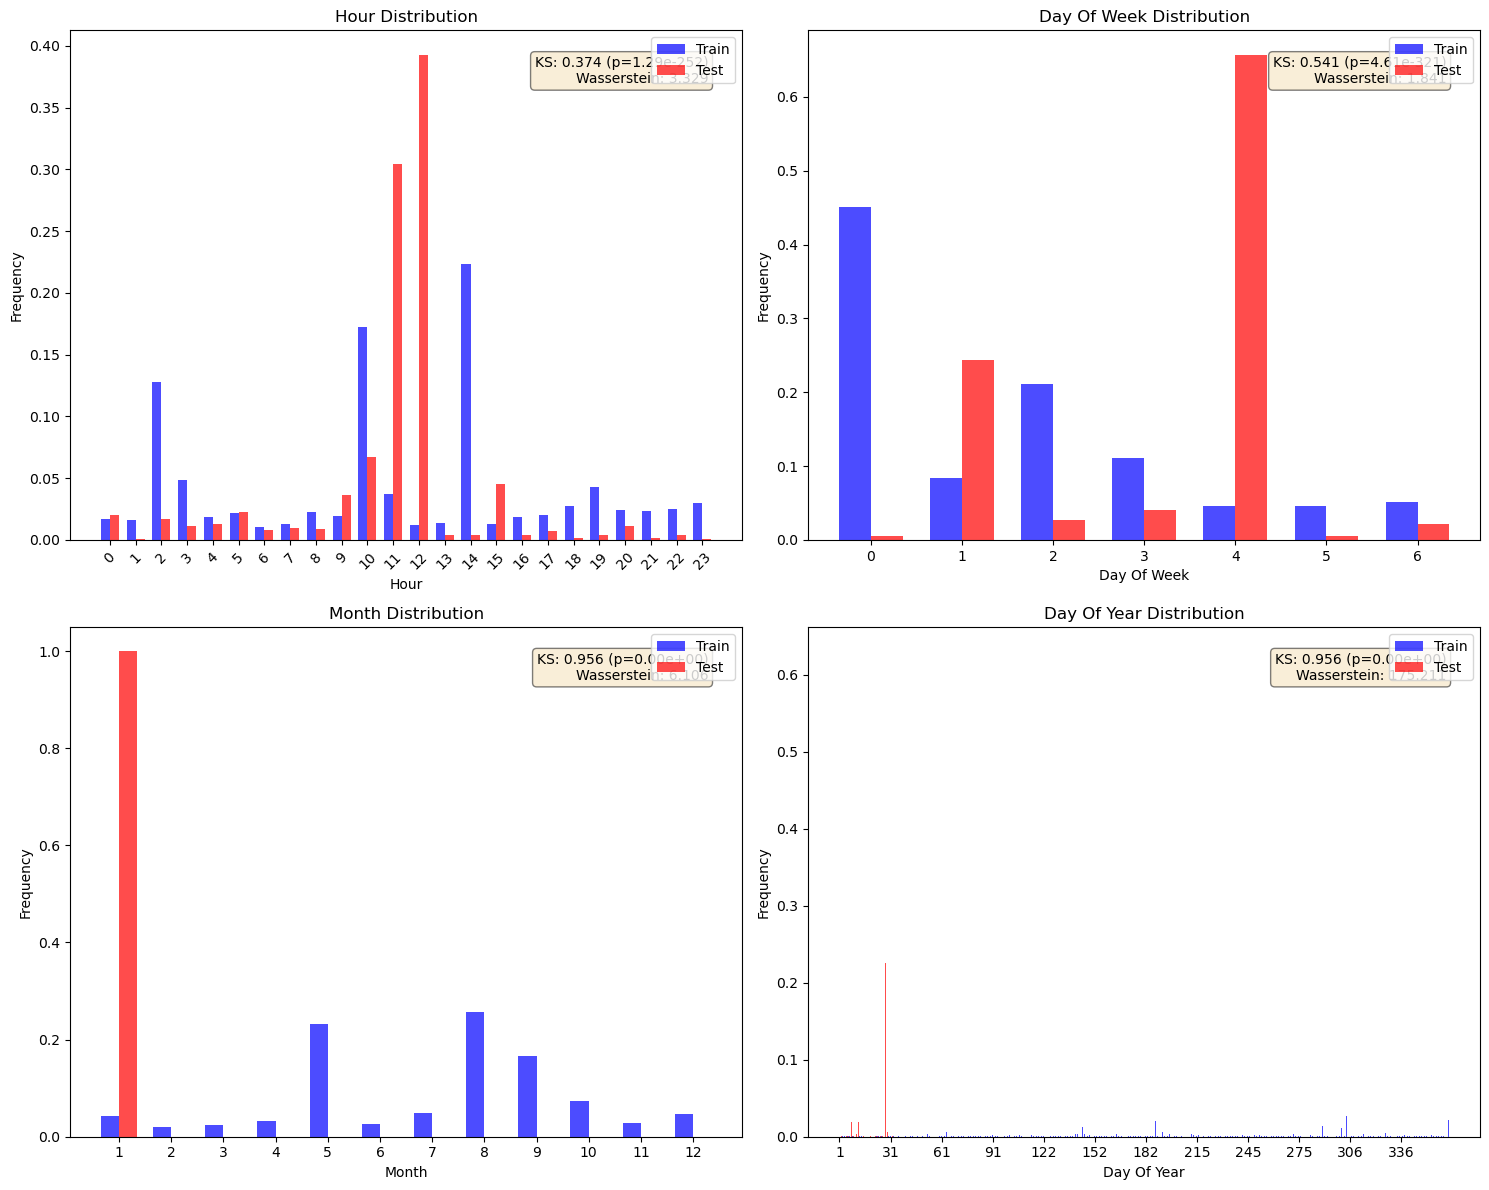


Temporal Distribution Statistics:
----------------------------------------------------------------------
Feature              KS Statistic    KS p-value      Wasserstein    
----------------------------------------------------------------------
hour                 0.3744          1.29e-252       3.3287         
day_of_week          0.5408          4.61e-321       1.8408         
month                0.9560          0.00e+00        6.1064         
day_of_year          0.9560          0.00e+00        175.2113       


In [4]:
# Analyze all temporal features
temporal_features = ['hour', 'day_of_week', 'month', 'day_of_year']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

temporal_stats = {}

for idx, feature in enumerate(temporal_features):
    ax = axes[idx]
    
    # Drop NaNs for statistics and plotting
    train_feat = train_df[feature].dropna()
    test_feat = test_df[feature].dropna()

    # Get value counts
    train_counts = train_feat.value_counts(normalize=True).sort_index()
    test_counts = test_feat.value_counts(normalize=True).sort_index()
    
    # Align indices
    all_values = sorted(set(train_counts.index) | set(test_counts.index))
    train_counts = train_counts.reindex(all_values, fill_value=0)
    test_counts = test_counts.reindex(all_values, fill_value=0)
    
    # Plot
    x = np.arange(len(all_values))
    width = 0.35
    
    ax.bar(x - width/2, train_counts.values, width, label='Train', alpha=0.7, color='blue')
    ax.bar(x + width/2, test_counts.values, width, label='Test', alpha=0.7, color='red')
    
    ax.set_xlabel(feature.replace('_', ' ').title())
    ax.set_ylabel('Frequency')
    ax.set_title(f'{feature.replace("_", " ").title()} Distribution')
    ax.legend()
    
    # Set x-axis labels
    if len(all_values) <= 24:  # For hour, day_of_week, month
        ax.set_xticks(x)
        ax.set_xticklabels([int(v) for v in all_values], rotation=45 if len(all_values) > 12 else 0)
    else:  # For day_of_year
        ax.set_xticks(x[::30])
        ax.set_xticklabels([int(v) for v in all_values[::30]])
    
    # Calculate statistics
    ks_stat = ks_2samp(train_feat, test_feat)
    wasserstein = wasserstein_distance(all_values, all_values, train_counts.values, test_counts.values)
    
    temporal_stats[feature] = {
        'ks_statistic': ks_stat.statistic,
        'ks_pvalue': ks_stat.pvalue,
        'wasserstein_distance': wasserstein
    }
    
    # Add statistics to plot
    stats_text = f'KS: {ks_stat.statistic:.3f} (p={ks_stat.pvalue:.2e})\nWasserstein: {wasserstein:.3f}'
    ax.text(0.95, 0.95, stats_text,
            transform=ax.transAxes, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Summary table
print("\nTemporal Distribution Statistics:")
print("-" * 70)
print(f"{'Feature':<20} {'KS Statistic':<15} {'KS p-value':<15} {'Wasserstein':<15}")
print("-" * 70)
for feature, stats in temporal_stats.items():
    print(f"{feature:<20} {stats['ks_statistic']:<15.4f} {stats['ks_pvalue']:<15.2e} {stats['wasserstein_distance']:<15.4f}")


 ## 4. Combined Spatio-Temporal Patterns

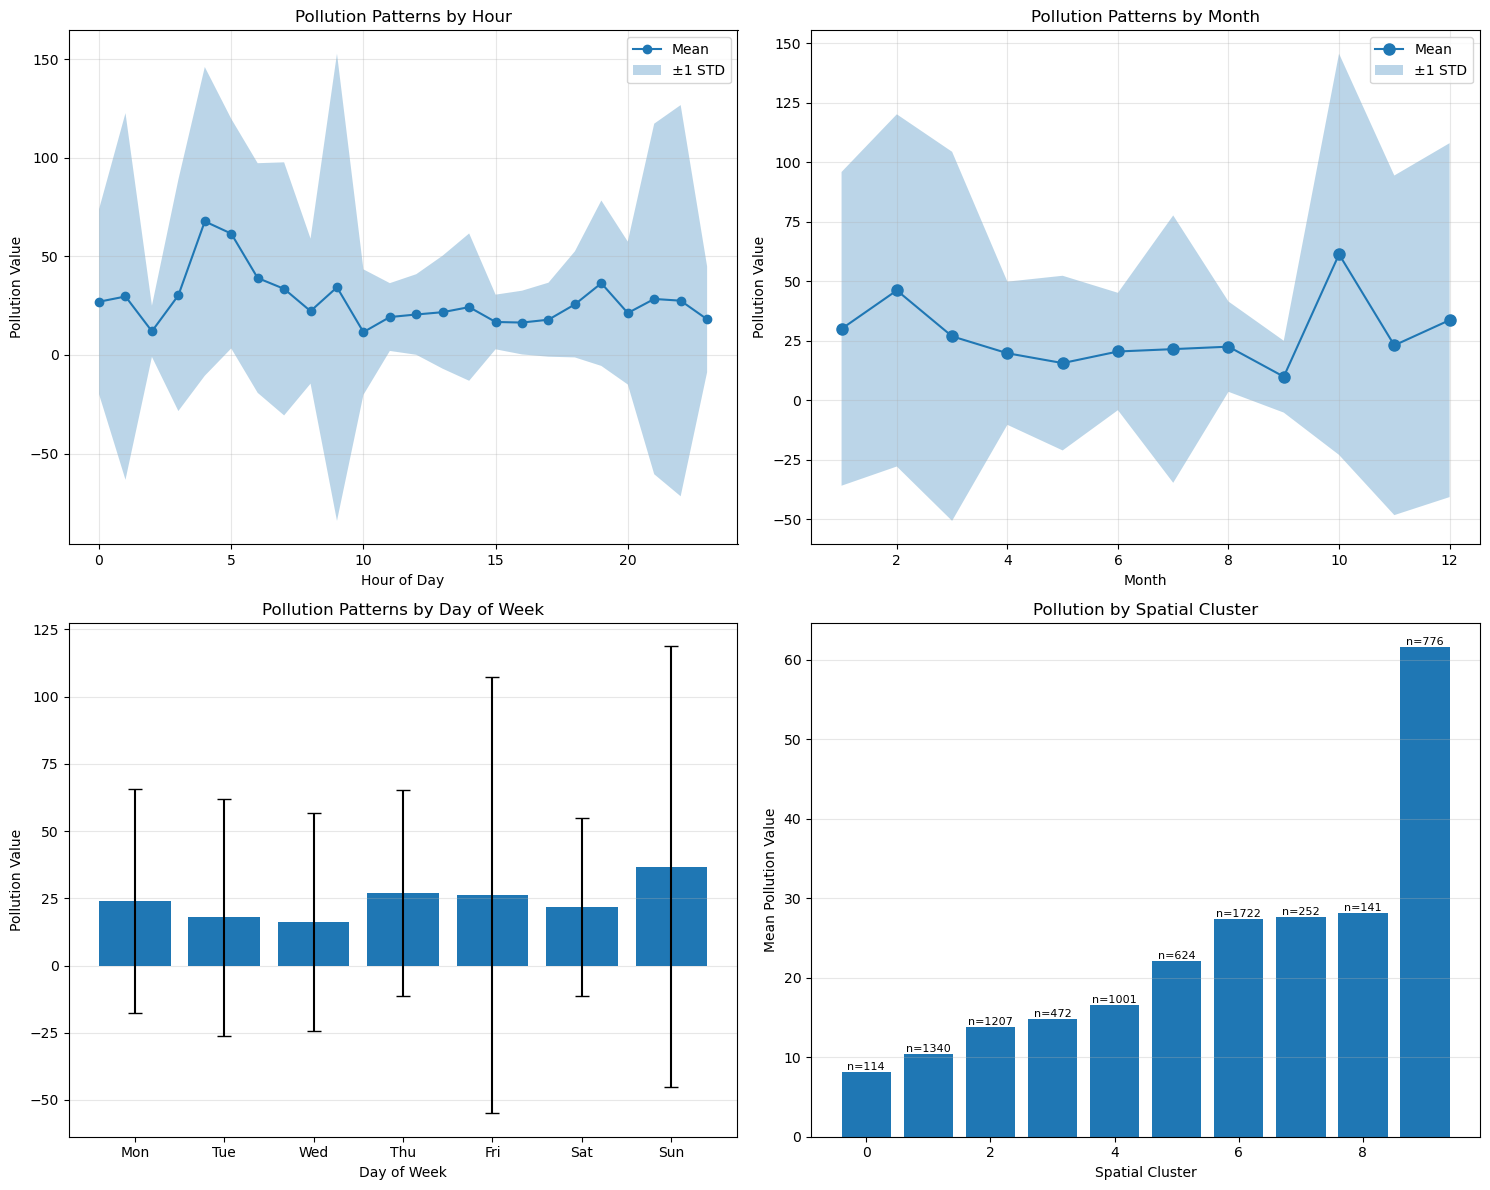

In [5]:
# Analyze pollution patterns by space and time
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 4.1 Pollution by hour
ax = axes[0, 0]
hourly_pollution = train_df.groupby('hour')['pollution_value'].agg(['mean', 'std'])
ax.plot(hourly_pollution.index, hourly_pollution['mean'], 'o-', label='Mean', markersize=6)
ax.fill_between(hourly_pollution.index, 
                hourly_pollution['mean'] - hourly_pollution['std'],
                hourly_pollution['mean'] + hourly_pollution['std'],
                alpha=0.3, label='±1 STD')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Pollution Value')
ax.set_title('Pollution Patterns by Hour')
ax.legend()
ax.grid(True, alpha=0.3)

# 4.2 Pollution by month
ax = axes[0, 1]
monthly_pollution = train_df.groupby('month')['pollution_value'].agg(['mean', 'std'])
ax.plot(monthly_pollution.index, monthly_pollution['mean'], 'o-', label='Mean', markersize=8)
ax.fill_between(monthly_pollution.index,
                monthly_pollution['mean'] - monthly_pollution['std'],
                monthly_pollution['mean'] + monthly_pollution['std'],
                alpha=0.3, label='±1 STD')
ax.set_xlabel('Month')
ax.set_ylabel('Pollution Value')
ax.set_title('Pollution Patterns by Month')
ax.legend()
ax.grid(True, alpha=0.3)

# 4.3 Pollution by day of week
ax = axes[1, 0]
dow_pollution = train_df.groupby('day_of_week')['pollution_value'].agg(['mean', 'std'])
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax.bar(dow_pollution.index, dow_pollution['mean'], yerr=dow_pollution['std'], capsize=5)
ax.set_xticks(range(7))
ax.set_xticklabels(days)
ax.set_xlabel('Day of Week')
ax.set_ylabel('Pollution Value')
ax.set_title('Pollution Patterns by Day of Week')
ax.grid(True, alpha=0.3, axis='y')

# 4.4 Spatial clustering of pollution
ax = axes[1, 1]
from sklearn.cluster import KMeans

# FIX: Create a copy and fill NaNs with the mean before using KMeans
coords_df = train_df[['latitude', 'longitude']].copy()
coords_df['latitude'].fillna(coords_df['latitude'].mean(), inplace=True)
coords_df['longitude'].fillna(coords_df['longitude'].mean(), inplace=True)
coords = coords_df.values

# Cluster locations
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
train_df_copy = train_df.copy() # Work on a copy to add the cluster label
train_df_copy['spatial_cluster'] = kmeans.fit_predict(coords)

# Calculate mean pollution per cluster
cluster_pollution = train_df_copy.groupby('spatial_cluster')['pollution_value'].mean().sort_values()
cluster_sizes = train_df_copy['spatial_cluster'].value_counts().sort_index()

# Create bar plot with cluster sizes
bars = ax.bar(range(len(cluster_pollution)), cluster_pollution.values)
ax.set_xlabel('Spatial Cluster')
ax.set_ylabel('Mean Pollution Value')
ax.set_title('Pollution by Spatial Cluster')

# Add cluster sizes as text
for i, (bar, size) in enumerate(zip(bars, cluster_sizes.loc[cluster_pollution.index])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'n={size}', ha='center', va='bottom', fontsize=8)

ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


 ## 5. Distribution Shift Impact Analysis

In [6]:
# Simulate what happens with different CV strategies
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

print("Comparing CV Strategies:")
print("-" * 60)

# Prepare simple features for quick testing
X = train_df[['latitude', 'longitude', 'hour', 'month', 'day_of_week']]
y = train_df['pollution_value']

# Add cyclical encoding
X['hour_sin'] = np.sin(2 * np.pi * X['hour'] / 24)
X['hour_cos'] = np.cos(2 * np.pi * X['hour'] / 24)
X['month_sin'] = np.sin(2 * np.pi * X['month'] / 12)
X['month_cos'] = np.cos(2 * np.pi * X['month'] / 12)
X = X.drop(columns=['hour', 'month'])


# FIX: Create copies and fill NaNs with the mean before modeling
X_model = X.copy()
y_model = y.copy()

# Impute features
for col in X_model.columns:
    if X_model[col].isnull().any():
        X_model[col].fillna(X_model[col].mean(), inplace=True)
# Impute target
if y_model.isnull().any():
    y_model.fillna(y_model.mean(), inplace=True)


# Strategy 1: Random KFold
print("\n1. Random KFold CV:")
kf_random = KFold(n_splits=5, shuffle=True, random_state=42)
random_scores = []

for fold, (train_idx, val_idx) in enumerate(kf_random.split(X_model)):
    X_tr, X_val = X_model.iloc[train_idx], X_model.iloc[val_idx]
    y_tr, y_val = y_model.iloc[train_idx], y_model.iloc[val_idx]
    
    model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
    model.fit(X_tr, y_tr)
    pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    random_scores.append(rmse)

print(f"   Average RMSE: {np.mean(random_scores):.4f} (±{np.std(random_scores):.4f})")

# Strategy 2: Spatial-based split
print("\n2. Spatial-based CV (latitude bands):")
spatial_scores = []
# Use the safe, imputed data for this strategy
lats = X_model['latitude'].values
lat_sorted_idx = np.argsort(lats)

for fold in range(5):
    fold_size = len(X_model) // 5
    val_start = fold * fold_size
    val_end = (fold + 1) * fold_size if fold < 4 else len(X_model)
    
    val_idx = lat_sorted_idx[val_start:val_end]
    train_idx = np.concatenate([lat_sorted_idx[:val_start], lat_sorted_idx[val_end:]])
    
    X_tr, X_val = X_model.iloc[train_idx], X_model.iloc[val_idx]
    y_tr, y_val = y_model.iloc[train_idx], y_model.iloc[val_idx]
    
    model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
    model.fit(X_tr, y_tr)
    pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    spatial_scores.append(rmse)

print(f"   Average RMSE: {np.mean(spatial_scores):.4f} (±{np.std(spatial_scores):.4f})")

# Strategy 3: Temporal-based split
print("\n3. Temporal-based CV (by month):")
temporal_scores = []
# Re-join with original month feature for splitting
X_model_with_month = X_model.join(train_df['month'])

for fold in range(5):
    # Use 2-3 months for validation
    val_months = [(fold * 2 + 1) % 12 + 1, (fold * 2 + 2) % 12 + 1]
    
    # Use the imputed dataframes for training and validation sets
    val_mask = X_model_with_month['month'].isin(val_months)
    train_mask = ~X_model_with_month['month'].isin(val_months)
    
    X_tr = X_model.loc[train_mask]
    X_val = X_model.loc[val_mask]
    y_tr = y_model.loc[train_mask]
    y_val = y_model.loc[val_mask]
    
    if len(X_val) > 0:
        model = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
        model.fit(X_tr, y_tr)
        pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, pred))
        temporal_scores.append(rmse)

print(f"   Average RMSE: {np.mean(temporal_scores):.4f} (±{np.std(temporal_scores):.4f})")

print("\nConclusion: Different CV strategies yield different estimates!")
print("The spatial/temporal-aware CV provides more realistic performance estimates")
print("when there are distribution shifts between train and test sets.")


Comparing CV Strategies:
------------------------------------------------------------

1. Random KFold CV:
   Average RMSE: 41.8367 (±5.6656)

2. Spatial-based CV (latitude bands):
   Average RMSE: 42.1497 (±26.9527)

3. Temporal-based CV (by month):
   Average RMSE: 55.3943 (±15.2538)

Conclusion: Different CV strategies yield different estimates!
The spatial/temporal-aware CV provides more realistic performance estimates
when there are distribution shifts between train and test sets.


 ## 6. Feature Importance with Distribution Awareness

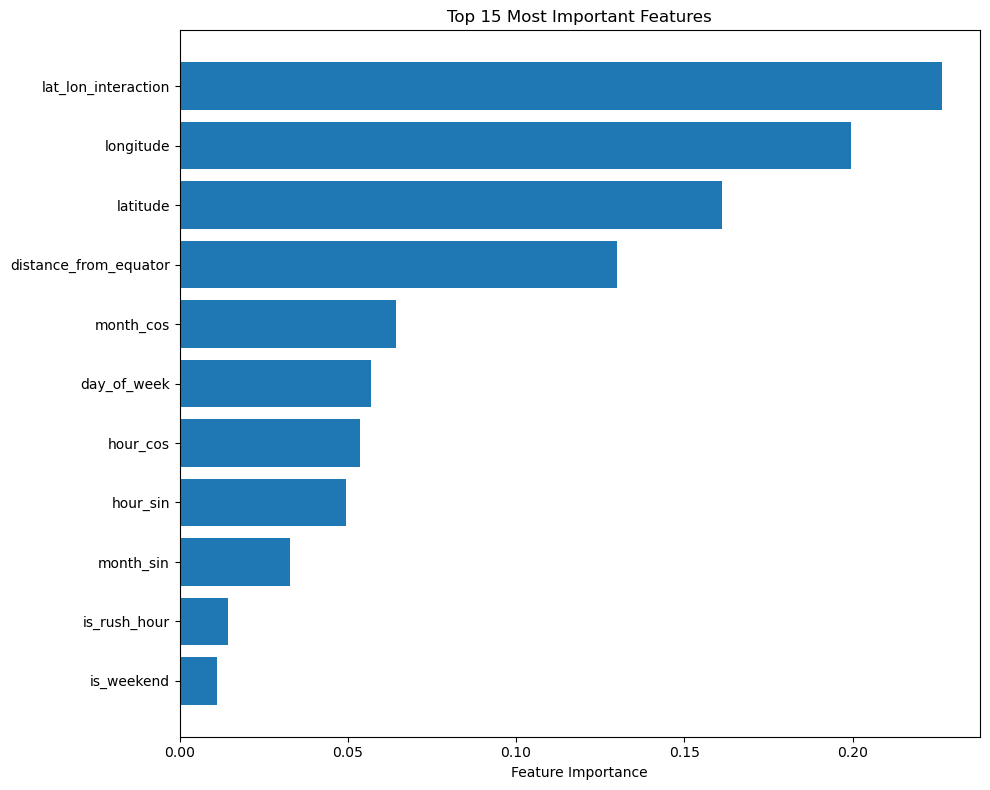

In [7]:
# Train a model and analyze feature importance
from sklearn.preprocessing import StandardScaler

# Create more features from the original dataframe
X_enhanced = X.copy()
X_enhanced['lat_lon_interaction'] = X_enhanced['latitude'] * X_enhanced['longitude']
X_enhanced['distance_from_equator'] = np.abs(X_enhanced['latitude'])
X_enhanced['is_weekend'] = (train_df['day_of_week'] >= 5).astype(int)
X_enhanced['is_rush_hour'] = train_df['hour'].isin([7, 8, 9, 17, 18, 19]).astype(int)

# FIX: Create a final copy and fill NaNs before scaling and modeling
X_enhanced_safe = X_enhanced.copy()
y_final_safe = y.copy()

for col in X_enhanced_safe.columns:
    if X_enhanced_safe[col].isnull().any():
        X_enhanced_safe[col].fillna(X_enhanced_safe[col].mean(), inplace=True)
if y_final_safe.isnull().any():
    y_final_safe.fillna(y_final_safe.mean(), inplace=True)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_enhanced_safe)

# Train model
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_scaled, y_final_safe)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_enhanced_safe.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


 ## 7. Summary and Recommendations

In [8]:
print("="*70)
print("DISTRIBUTION SHIFT ANALYSIS SUMMARY")
print("="*70)

print("\n1. SPATIAL DISTRIBUTION SHIFTS:")
print(f"   - Latitude KS statistic: {lat_ks.statistic:.4f} (p={lat_ks.pvalue:.2e})")
print(f"   - Longitude KS statistic: {lon_ks.statistic:.4f} (p={lon_ks.pvalue:.2e})")
print("   → Test locations are significantly different from train locations")

print("\n2. TEMPORAL DISTRIBUTION SHIFTS:")
for feature, stats in temporal_stats.items():
    if stats['ks_pvalue'] < 0.05:
        print(f"   - {feature}: Wasserstein distance = {stats['wasserstein_distance']:.4f} (significant shift)")

print("\n3. KEY FINDINGS:")
print("   - Both spatial and temporal distributions differ between train and test")
print("   - Standard random CV will likely overestimate model performance")
print("   - Need specialized features and validation to bridge distribution gaps")

print("\n4. SOLUTION STRATEGIES:")
print("   ✓ Spatial clustering features to generalize across locations")
print("   ✓ Cyclical temporal encoding for better time patterns")
print("   ✓ Distribution-aware CV for realistic validation")
print("   ✓ Domain adaptation techniques (e.g., importance weighting)")
print("   ✓ Ensemble methods to improve robustness")

print("\n5. NEXT STEPS:")
print("   - Implement a robust SpatioTemporalCV for model validation.")
print("   - Experiment with domain adaptation methods like adversarial validation.")
print("   - Monitor performance on both spatial and temporal subsets of the test data.")

DISTRIBUTION SHIFT ANALYSIS SUMMARY

1. SPATIAL DISTRIBUTION SHIFTS:
   - Latitude KS statistic: 0.3457 (p=1.52e-214)
   - Longitude KS statistic: 0.2957 (p=3.77e-156)
   → Test locations are significantly different from train locations

2. TEMPORAL DISTRIBUTION SHIFTS:
   - hour: Wasserstein distance = 3.3287 (significant shift)
   - day_of_week: Wasserstein distance = 1.8408 (significant shift)
   - month: Wasserstein distance = 6.1064 (significant shift)
   - day_of_year: Wasserstein distance = 175.2113 (significant shift)

3. KEY FINDINGS:
   - Both spatial and temporal distributions differ between train and test
   - Standard random CV will likely overestimate model performance
   - Need specialized features and validation to bridge distribution gaps

4. SOLUTION STRATEGIES:
   ✓ Spatial clustering features to generalize across locations
   ✓ Cyclical temporal encoding for better time patterns
   ✓ Distribution-aware CV for realistic validation
   ✓ Domain adaptation techniques (e